In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import cv2
import glob
import albumentations as A 
import matplotlib.pyplot as plt
from torch import optim
import logging
from tqdm import tqdm
import torchvision

from dataset import *

In [3]:
IMG_SIZE = 64
BATCH_SIZE = 2
INPUT_CHANELS = 3
T = 250
TIME_DIM = 256
LR = 1e-3
EPOCHS = 30

In [4]:
# Define a custom dataset class
class CorrectionImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, file_list=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_name)

        im = expose_image(image)
        mask = get_masks(im)
        
        if self.transform:
            transformed_image = self.transform(image)
            transformed_maks = self.transform(mask)
        
        return image, mask



In [5]:
def expose_image(image):
    image = np.array(image)
    exposition = A.RandomBrightnessContrast(p=1, brightness_limit=(0.2,0.2), contrast_limit=(0.2, 0.2))
    exposed_image = exposition(image=image)['image']
    return exposed_image

In [6]:
def get_masks(image):
    mask = image.mean(axis=2) == 255
    return mask 

In [7]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [8]:
from dataset import * 

In [9]:
train_images = ['data/training/GT_IMAGES/' + x for x in os.listdir('data/training/GT_IMAGES')]
val_images = ['data/validation/GT_IMAGES/' + x for x in os.listdir('data/validation/GT_IMAGES')]

In [15]:
train_dataset = CorrectionImageDataset(train_images, train=True, transform=transform)
validation_dataset = CorrectionImageDataset(val_images, train=True, transform=transform)

In [16]:
image, mask = train_dataset.__getitem__(17)

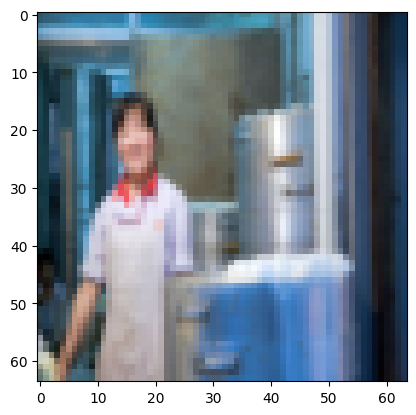

In [17]:
plt.imshow(np.einsum('abc->bca', image)) 

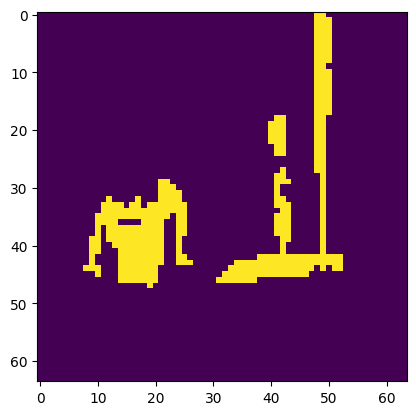

In [18]:
plt.imshow(mask)

In [14]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)


# Training

In [19]:
from ddpm.ddpm import Diffusion
from ddpm.model import UNet

In [32]:
experiment_name = 'test'

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

In [40]:
def save_images(images, path, show=True, title=None, nrow=10):
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    if title is not None:
        plt.title(title)
    plt.imshow(ndarr)
    plt.axis('off')
    if path is not None:
        plt.savefig(path, bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
    plt.close()


def create_result_folders(experiment_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", experiment_name), exist_ok=True)
    os.makedirs(os.path.join("results", experiment_name), exist_ok=True)

03:08:20 - INFO: Starting epoch 1:
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1768/1768 [56:11:43<00:00, 114.43s/it, MSE=0.0159]
11:20:04 - INFO: Sampling 1 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [01:04<00:00,  3.84it/s]


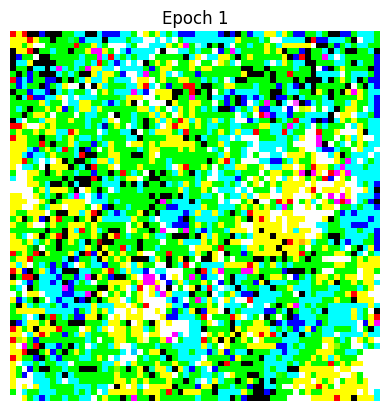

11:21:10 - INFO: Starting epoch 2:
 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1419/1768 [1:08:08<16:45,  2.88s/it, MSE=0.0181]


KeyboardInterrupt: 

In [42]:
create_result_folders(experiment_name)

model = UNet(img_size=IMG_SIZE, c_in=INPUT_CHANELS, c_out=INPUT_CHANELS, 
             time_dim=TIME_DIM,channels=32, device=device).to(device)
diffusion = Diffusion(img_size=IMG_SIZE, T=T, beta_start=1e-4, beta_end=0.02, device=device)

optimizer = optim.AdamW(model.parameters(), lr=LR)
mse = torch.nn.MSELoss() # use MSE loss 

logger = SummaryWriter(os.path.join("runs", experiment_name))
l = len(train_dataloader)

for epoch in range(1, EPOCHS + 1):
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(train_dataloader)

    for i, (images, masks) in enumerate(pbar):
        images = images.to(device)
        masks = masks.to(device)

        # TASK 4: implement the training loop
        t = diffusion.sample_timesteps(images.shape[0]).to(device) # line 3 from the Training algorithm
        x_t, noise = diffusion.q_sample(images, t) # inject noise to the images (forward process), HINT: use q_sample
        
        predicted_noise = model(x_t, t) # predict noise of x_t using the UNet
        loss = mse(noise, predicted_noise) # loss between noise and predicted noise

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        pbar.set_postfix(MSE=loss.item())
        logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

    sampled_images = diffusion.p_sample_loop(model, batch_size=images.shape[0])
    save_images(images=sampled_images, path=os.path.join("results", experiment_name, f"{epoch}.jpg"),
                    show=True, title=f'Epoch {epoch}')
    torch.save(model.state_dict(), os.path.join("models", experiment_name, f"weights-{epoch}.pt"))    

FileNotFoundError: [Errno 2] No such file or directory: 'results/test/1.jpg'

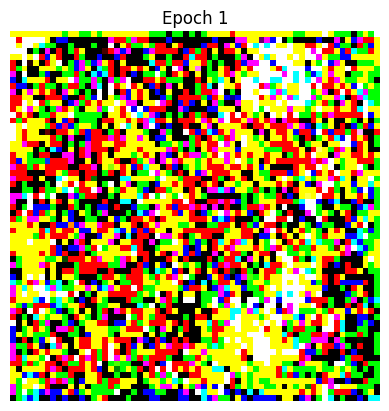